# Final Project
## 1. Read the datasets

In [1]:
import pandas as pd
import numpy as np
np.random.seed(30224)

In [2]:
# Read train1.csv and train2.csv
train1 = pd.read_csv("./../data/train1.csv", header=0)
train2 = pd.read_csv("./../data/train2.csv", header=0)

In [3]:
train1.head(5)

,headline,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1


In [4]:
train2.head(5)

,label,title
0,news,China and Economic Reform: Xi Jinping’s Track ...
1,news,Trade to Be a Big Topic in Theresa May’s U.S. ...
2,clickbait,"The Top Beaches In The World, According To Nat..."
3,clickbait,Sheriff’s Report Provides New Details on Tamir...
4,news,Surgeon claiming he will transplant volunteer'...


In [5]:
# Check for missing data
train1[train1.isna().any(axis=1)]

,headline,clickbait


In [6]:
train2[train2.isna().any(axis=1)]

,label,title


In [7]:
# Combine datasets
train2["clickbait"] = np.where(train2["label"] == "clickbait", 1, 0)
train2["headline"] = train2["title"]

df = pd.concat([train1, train2], join="inner")

## 2. Exploratory data analysis

In [8]:
# Show number of clickbait vs non-clickbait titles in the dataset
df["clickbait"].value_counts()

0    32739
1    20290
Name: clickbait, dtype: int64

In [9]:
# Tokenize of news headlines
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
nltk.download('punkt')
nltk.download('stopwords')

stop_tokens = set(stopwords.words("english")).union(set(string.punctuation))

def tokenize(sentence: str):
    tokens = word_tokenize(sentence)
    tokens = [token.lower() for token in tokens if token not in stop_tokens]
    return tokens

df["headline_tokens"] = df["headline"].apply(tokenize)

[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# Compare title, word lengths of clickbait vs non-clickbait headlines
df["headline_length"] = df["headline_tokens"].apply(len)
df["avg_word_length"] = df["headline_tokens"].apply(lambda tokens: sum([len(token) for token in tokens]) / len(tokens))

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 0, 'Headline length')

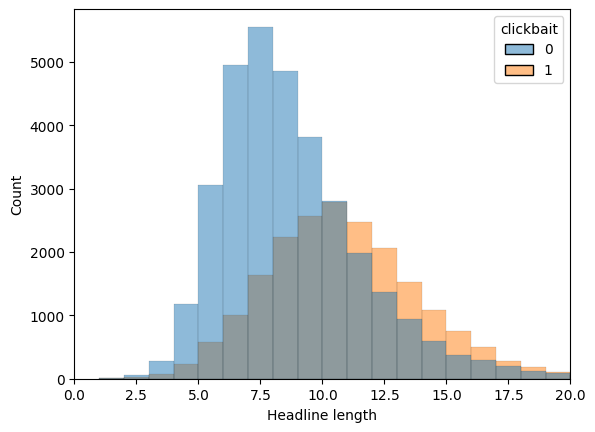

In [12]:
sns.histplot(df, x="headline_length", hue="clickbait", binwidth=1)
plt.xlim(0, 20)
plt.xlabel("Headline length")

Text(0.5, 0, 'Average word length')

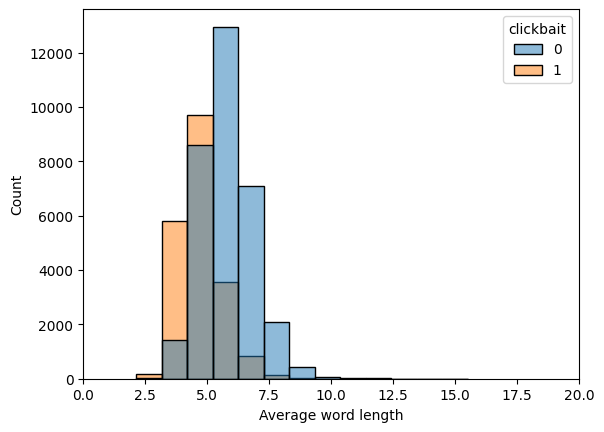

In [13]:
sns.histplot(df, x="avg_word_length", hue="clickbait", binwidth=1)
plt.xlim(0, 20)
plt.xlabel("Average word length")

In [14]:
# Compare word cloud of clickbait vs non-clickbait headlines
from wordcloud import WordCloud

In [15]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=stopwords.words("english"))
clickbait_text = df[df["clickbait"] == 1]["headline"].str.cat()
news_text = df[df["clickbait"] == 0]["headline"].str.cat()

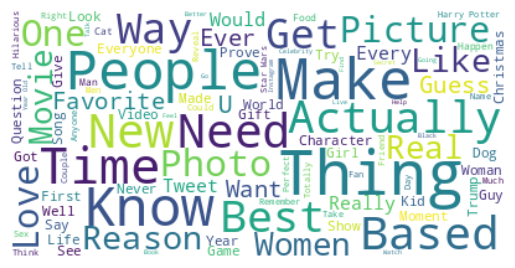

In [16]:
plt.figure()
plt.imshow(wordcloud.generate(clickbait_text), interpolation="bilinear")
plt.axis("off")
plt.show()

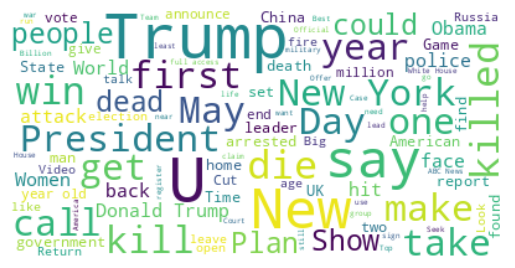

In [17]:
plt.figure()
plt.imshow(wordcloud.generate(news_text), interpolation="bilinear")
plt.axis("off")
plt.show()

## 3. Construct and train model

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
# Split train-test data
X_train, X_test, y_train, y_test = train_test_split(df["headline"], df["clickbait"], test_size=0.2, random_state=30224)

In [20]:
# Create a LSA pipeline for preprocessing the text
lemmatizer = WordNetLemmatizer()

def tokenizer(doc):
    return [lemmatizer.lemmatize(word.lower()) for word in word_tokenize(doc)]

tfidf_vectorizer = TfidfVectorizer(
    tokenizer = tokenizer,
    stop_words = 'english',
    lowercase = False)

svd = TruncatedSVD(n_components=100, random_state=30224)

lsa = make_pipeline(tfidf_vectorizer, svd)

# Apply LSA on the train text
X_train_lsa = lsa.fit_transform(X_train)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/codespace/.local/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [21]:
# Train a random forest classifier
estimator = RandomForestClassifier(n_estimators=100, random_state=30224)
model = estimator.fit(X_train_lsa, y_train)

In [22]:
# Evaluate model
X_test_lsa = lsa.transform(X_test)
y_pred = model.predict(X_test_lsa)

print("Accuracy on test dataset:", accuracy_score(y_test, y_pred))

Accuracy on test dataset: 0.8666792381670753


[]

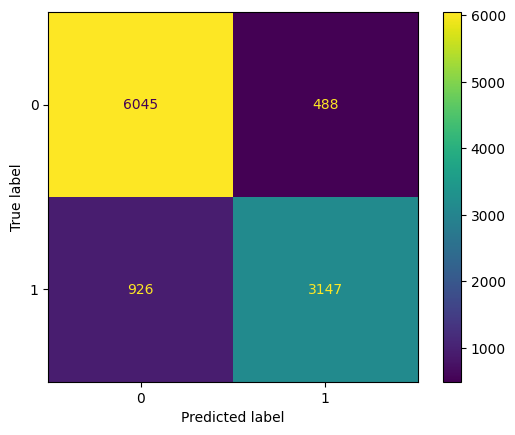

In [23]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.plot()

## 4. Interprete results

In [24]:
# Understand the prediction of each term of the 
X_term = lsa["truncatedsvd"].components_.T
y_term = model.predict_proba(X_term)

top_clickbait_ids = np.argpartition(y_term[:,0], 25)[:25]
top_news_ids = np.argpartition(y_term[:,1], 25)[:25]

terms = lsa["tfidfvectorizer"].vocabulary_
inv_term = {v: k for k, v in terms.items()}


In [25]:
print("Top clickbait terms:")
for id in top_clickbait_ids:
    print(y_term[id, 1], "-", inv_term[id])

Top clickbait terms:
0.98 - 17
0.97 - 27
1.0 - actually
0.97 - taylor
0.97 - 23
0.94 - love
0.94 - dad
0.98 - 2015
0.94 - guess
0.96 - chill
0.95 - swift
0.98 - guy
0.97 - 'll
0.94 - sign
0.99 - zodiac
0.96 - based
0.94 - people
0.94 - 22
0.93 - ``
0.93 - 29
0.94 - color
0.94 - ''
0.93 - game
0.93 - 21
0.93 - understand


In [26]:
print("Top news terms:")
for id in top_news_ids:
    print(y_term[id, 0], inv_term[id])

Top news terms:
0.99 european
1.0 ;
0.99 security
1.0 leader
1.0 trade
1.0 email
0.99 officer
1.0 iran
0.99 air
1.0 interview
0.99 oil
0.99 announces
0.99 delay
0.99 warns
0.99 governor
0.99 minister
0.99 lead
0.98 judge
0.99 japan
0.98 resigns
0.98 candidate
0.98 near
0.98 israel
0.98 concern
0.98 israeli


In [32]:
# Create a function to predict whether an article title is clickbait
def verify(headlines):
    headline_lsa = lsa.transform(headlines)
    headline_pred = model.predict(headline_lsa)
    results = np.where(headline_pred == 0, "News", "Clickbait")
    print(results)

In [35]:
verify(["Yemen’s Houthis ‘will not stop’ attacks on ships in Red Sea unless Israel ends war in Gaza",
        "Motorists warned to ‘expect delays’ following multi-vehicle crash on M50",
        "Intriguing facts about Popes"])

['News' 'News' 'Clickbait']


In [29]:
# Study top false predictions
y_pred_proba = model.predict_proba(X_test_lsa)

top_false_positive_ids = np.argsort(y_test - y_pred_proba[:,1])[:10]
top_false_negative_ids = np.argsort(y_pred_proba[:,1] - y_test)[:10]

In [30]:
print("Top false positive preditions:")
for id in top_false_positive_ids:
    print(y_test.iloc[id], y_pred[id], X_test.iloc[id])

Top false positive preditions:
0 1 10 things you need to know before the opening bell
0 1 31 Delicious Things To Cook In May
0 1 What you need to stream on Thanksgiving weekend
0 1 VPNs are getting extremely popular â here's everything you need to know about them
0 1 Five things we learned from the Sally Yates hearing
0 1 Those brutally small airplane seats may soon be a thing of the past
0 1 Janet Jackson Shares Adorable First Photo With Baby Boy Eissa
0 1 People Are Shook Over How Hot Young Justin Trudeau Was
0 1 What's It Like Being Black in the White-Dominated Weed Industry
0 1 Cat Shreds On A Sled


In [31]:
print("Top false negative preditions:")
for id in top_false_negative_ids:
    print(y_test.iloc[id], y_pred[id], X_test.iloc[id])

Top false negative preditions:
1 0 U.S. Should Clinch Second Round Pass With Win Against Familiar Foe Sweden
1 0 This Presidential Election Will Be Decided On A Coin Toss
1 0 Louisville player confuses CBS reporter for Jacksonville State spy
1 0 Tons of juice flood Russian town after factory accident
1 0 Weaponized Police Drones Are Coming
1 0 From Franklin Graham to Tony Campolo, some evangelical leaders are splitting over gay marriage
1 0 Top modelling agencies and their trade association fined £1.5m for collusion and price-fixing
1 0 British Blue Chips Snub Investor Calls to Show CEO Pay Ratio
1 0 Brightly-lit orange UFO filmed hovering over French coastal town baffles residents
1 0 Three TSA Agents Arrested for Drug Smuggling Ring at San Francisco International Airport
